# Monitoring Analyst Test

This notebook aims to implement a real-time monitoring system for transaction anomalies. The system will:

1. Ingest transaction data via an endpoint.
2. Classify transactions as failed, denied, reversed, or approved.
3. Detect anomalies using rule-based and machine learning methods.
4. Send alerts to relevant teams when anomalies are detected.
5. Provide real-time visualization of transaction data.

## Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

## Exploratory Data Analysis

Let's start by understanding the data.

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

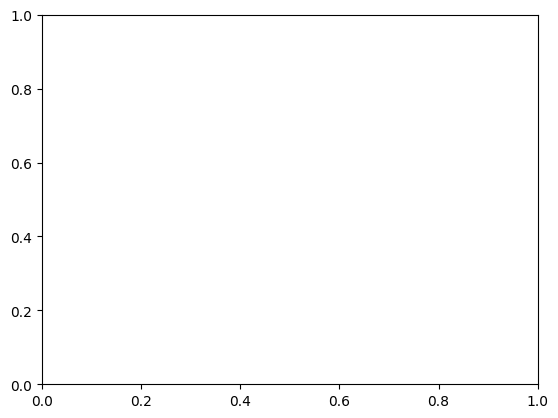

In [8]:
# Importing the data
transactions_2 = pd.read_csv("transactions_2.csv")
transactions_1 = pd.read_csv("transactions_1.csv")

# Concating the two csv files into one dataframe
transactions_concated = pd.concat([transactions_1, transactions_2]).sort_values(by='time').reset_index(drop=True)

print(transactions_concated['status'].unique())

# Função para converter string "HHh MM" para "HH:MM:00"
def convert_to_time_format(time_str):
    parts = time_str.split('h ')
    hour = parts[0].zfill(2)  # Garantir que tenha dois dígitos
    minute = parts[1].zfill(2)  # Garantir que tenha dois dígitos
    return f"{hour}:{minute}:00"

# Aplicar a função para converter a coluna
transactions_concated['time'] = pd.to_datetime(transactions_concated['time'].apply(convert_to_time_format), format='%H:%M:%S')
transactions_1['time'] = pd.to_datetime(transactions_1['time'].apply(convert_to_time_format), format='%H:%M:%S')
transactions_2['time'] = pd.to_datetime(transactions_2['time'].apply(convert_to_time_format), format='%H:%M:%S')

sns.kdeplot(x=transactions_2['time'], y=transactions_2['F1'])
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()

C:\Users\cassi\AppData\Local\Temp\ipykernel_16248\28672007.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = pd.to_datetime(filtered_df['time'], format='%H:%M:%S').dt.time
C:\Users\cassi\AppData\Local\Temp\ipykernel_16248\28672007.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time_in_minutes'] = filtered_df['time'].apply(lambda x: x.hour * 60 + x.minute)
C:\Users\cassi\AppData\Local\Temp\ipykernel_16248\28672007.py:27: SettingWithCopyWarning: 
A value is trying t

          time    status   F1  time_in_minutes  anomaly
0     00:00:00  reversed    7                0       -1
3     00:00:00    denied    3                0       -1
7     00:01:00  reversed    2                1       -1
9     00:01:00    denied   12                1       -1
10    00:02:00  reversed    5                2       -1
...        ...       ...  ...              ...      ...
2719  17:22:00    denied  105             1042       -1
2724  17:23:00    denied  110             1043       -1
2728  17:24:00    denied  111             1044       -1
2733  17:25:00    denied   98             1045       -1
2750  17:28:00    denied   59             1048       -1

[105 rows x 5 columns]


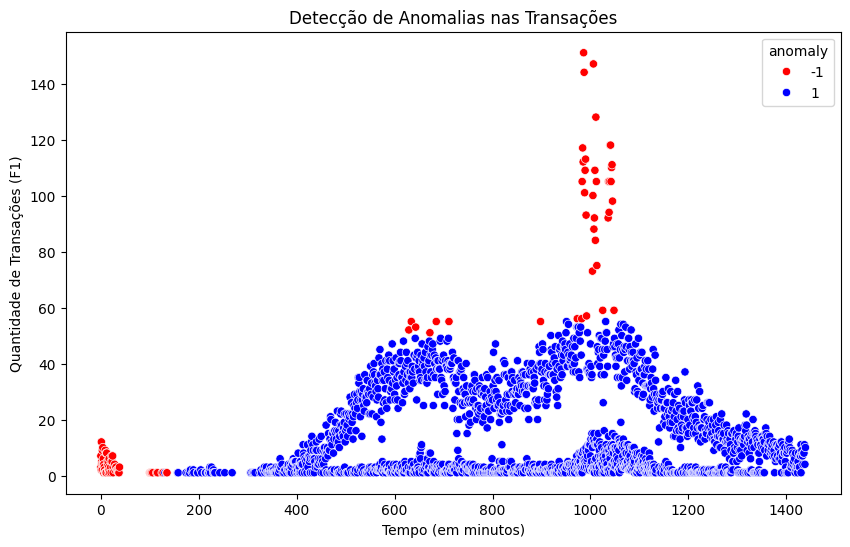

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

df = transactions_2

# Filtrar para os status 'failed', 'reversed', 'denied'
statuses_of_interest = ['failed', 'reversed', 'denied']
filtered_df = df[df['status'].isin(statuses_of_interest)]

# Converter a coluna 'time' para datetime (se necessário)
filtered_df['time'] = pd.to_datetime(filtered_df['time'], format='%H:%M:%S').dt.time

# Converter 'time' para minutos desde o início do dia para simplificar
filtered_df['time_in_minutes'] = filtered_df['time'].apply(lambda x: x.hour * 60 + x.minute)

# Usar apenas as colunas necessárias para a detecção de anomalias
X = filtered_df[['time_in_minutes', 'F1']]

# Definir e treinar o modelo Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)

# Prever anomalias
filtered_df['anomaly'] = model.predict(X)

# Filtrar anomalias
anomalies = filtered_df[filtered_df['anomaly'] == -1]

print(anomalies)

# Plotar os resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='time_in_minutes', y='F1', hue='anomaly', palette=['red', 'blue'])
plt.title('Detecção de Anomalias nas Transações')
plt.xlabel('Tempo (em minutos)')
plt.ylabel('Quantidade de Transações (F1)')
plt.show()


Resultados para o status 'failed':
          time  status  F1  time_in_minutes  anomaly
680   08:03:00  failed   1              483       -1
1266  10:50:00  failed   1              650       -1
1380  11:20:00  failed   1              680       -1
1655  12:39:00  failed   1              759       -1
1659  12:40:00  failed   1              760        1
...        ...     ...  ..              ...      ...
3114  18:48:00  failed   4             1128        1
3120  18:49:00  failed   4             1129        1
3126  18:50:00  failed   2             1130        1
3222  19:24:00  failed   1             1164       -1
3681  22:07:00  failed   2             1327       -1

[167 rows x 5 columns]

Anomalias para o status 'failed':
          time  status  F1  time_in_minutes  anomaly
680   08:03:00  failed   1              483       -1
1266  10:50:00  failed   1              650       -1
1380  11:20:00  failed   1              680       -1
1655  12:39:00  failed   1              759       -1
1733 

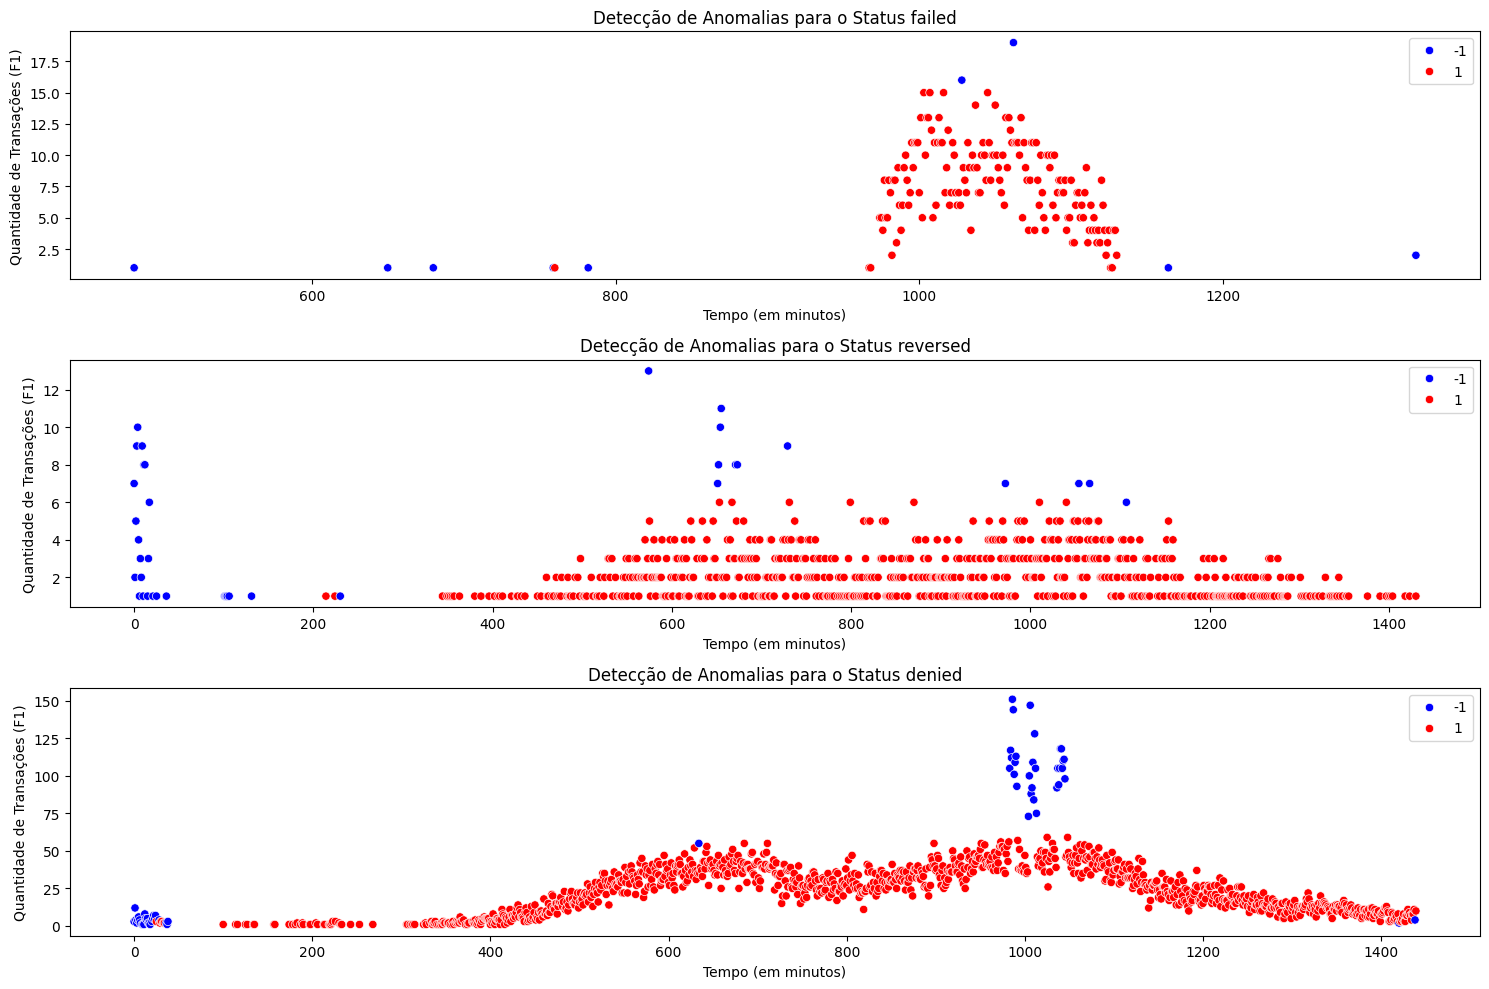

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns


df = transactions_2

def detect_anomalies(df, status):
    # Filtrar para um status específico
    status_df = df[df['status'] == status].copy()
    
    # Converter a coluna 'time' para datetime (se necessário)
    status_df['time'] = pd.to_datetime(status_df['time'], format='%H:%M:%S').dt.time
    
    # Converter 'time' para minutos desde o início do dia para simplificar
    status_df['time_in_minutes'] = status_df['time'].apply(lambda x: x.hour * 60 + x.minute)
    
    # Usar apenas as colunas necessárias para a detecção de anomalias
    X = status_df[['time_in_minutes', 'F1']]
    
    # Definir e treinar o modelo Isolation Forest
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X)
    
    # Prever anomalias
    status_df['anomaly'] = model.predict(X)
    
    # Filtrar anomalias
    anomalies = status_df[status_df['anomaly'] == -1]
    
    return status_df, anomalies

statuses_of_interest = ['failed', 'reversed', 'denied']
results = {}
anomalies_dict = {}

for status in statuses_of_interest:
    status_results, status_anomalies = detect_anomalies(df, status)
    results[status] = status_results
    anomalies_dict[status] = status_anomalies

# Exibir resultados
for status in statuses_of_interest:
    print(f"Resultados para o status '{status}':")
    print(results[status])
    print(f"\nAnomalias para o status '{status}':")
    print(anomalies_dict[status])
    print("\n")

# Plotar os resultados para cada status
plt.figure(figsize=(15, 10))

for i, status in enumerate(statuses_of_interest):
    plt.subplot(3, 1, i + 1)
    sns.scatterplot(data=results[status], x='time_in_minutes', y='F1', hue='anomaly', palette=['blue', 'red'])
    plt.title(f'Detecção de Anomalias para o Status {status}')
    plt.xlabel('Tempo (em minutos)')
    plt.ylabel('Quantidade de Transações (F1)')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Resultados para o status 'failed':
          time  status  F1  time_in_minutes
680   08:03:00  failed   1              483
1266  10:50:00  failed   1              650
1380  11:20:00  failed   1              680
1655  12:39:00  failed   1              759
1659  12:40:00  failed   1              760
...        ...     ...  ..              ...
3114  18:48:00  failed   4             1128
3120  18:49:00  failed   4             1129
3126  18:50:00  failed   2             1130
3222  19:24:00  failed   1             1164
3681  22:07:00  failed   2             1327

[167 rows x 4 columns]

Pontos de mudança para o status 'failed':
[130, 167]


Resultados para o status 'reversed':
          time    status  F1  time_in_minutes
0     00:00:00  reversed   7                0
7     00:01:00  reversed   2                1
10    00:02:00  reversed   5                2
19    00:03:00  reversed   9                3
21    00:04:00  reversed  10                4
...        ...       ...  ..              ..

<Figure size 1500x1000 with 0 Axes>

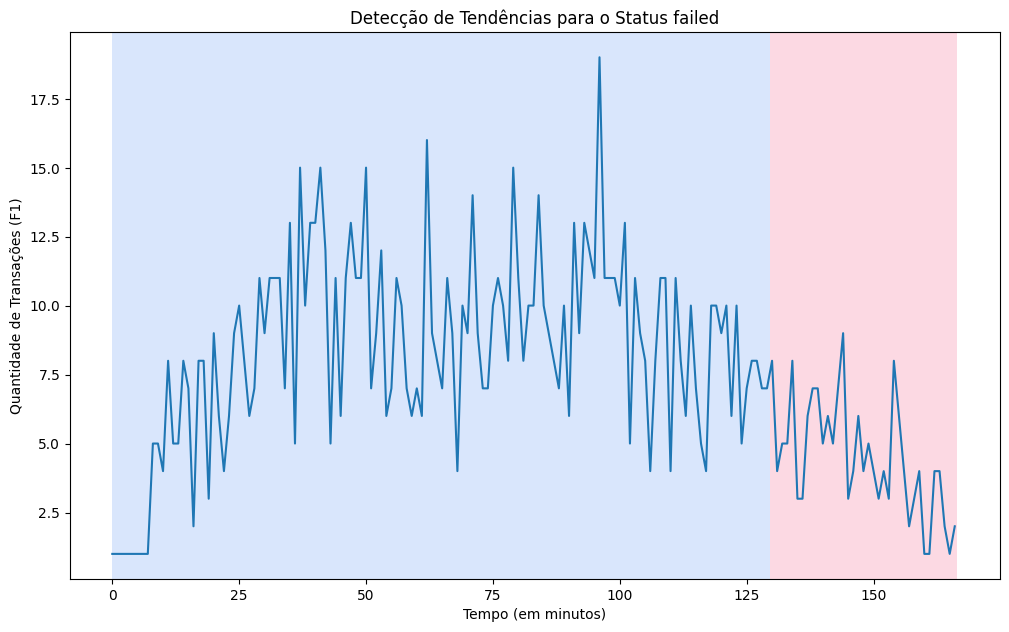

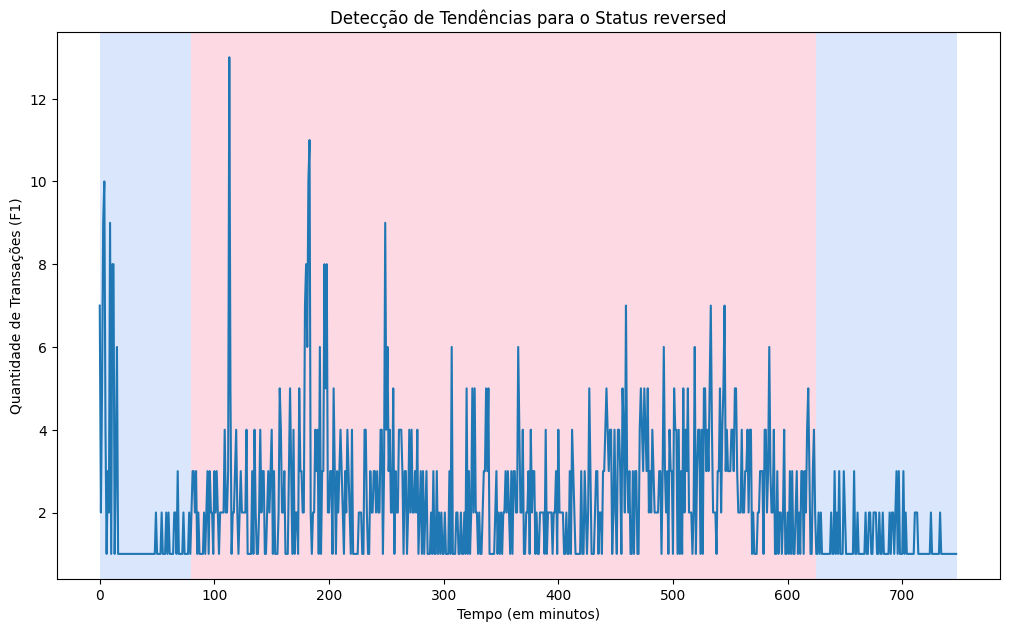

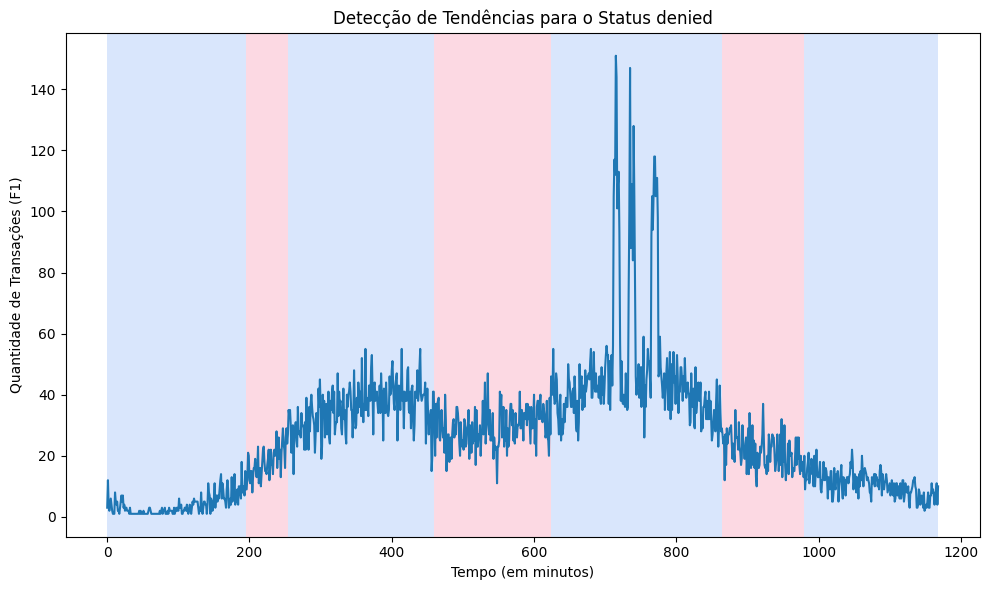

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

# Exemplo de criação de DataFrame

df = transactions_2
def detect_trends(df, status):
    # Filtrar para um status específico
    status_df = df[df['status'] == status].copy()
    
    # Converter a coluna 'time' para datetime (se necessário)
    status_df['time'] = pd.to_datetime(status_df['time'], format='%H:%M:%S').dt.time
    
    # Converter 'time' para minutos desde o início do dia para simplificar
    status_df['time_in_minutes'] = status_df['time'].apply(lambda x: x.hour * 60 + x.minute)
    
    # Ordenar por tempo
    status_df = status_df.sort_values(by='time_in_minutes')
    
    # Usar apenas a coluna 'F1' para detectar mudanças
    signal = status_df['F1'].values
    
    # Detecção de rupturas
    model = rpt.Pelt(model="rbf").fit(signal)
    breakpoints = model.predict(pen=10)
    
    return status_df, breakpoints

statuses_of_interest = ['failed', 'reversed', 'denied']
results = {}
breakpoints_dict = {}

for status in statuses_of_interest:
    status_results, breakpoints = detect_trends(df, status)
    results[status] = status_results
    breakpoints_dict[status] = breakpoints

# Exibir resultados
for status in statuses_of_interest:
    print(f"Resultados para o status '{status}':")
    print(results[status])
    print(f"\nPontos de mudança para o status '{status}':")
    print(breakpoints_dict[status])
    print("\n")

# Plotar os resultados para cada status
plt.figure(figsize=(15, 10))

for i, status in enumerate(statuses_of_interest):
    signal = results[status]['F1'].values
    breakpoints = breakpoints_dict[status]
    rpt.display(signal, breakpoints, figsize=(10, 6))
    plt.title(f'Detecção de Tendências para o Status {status}')
    plt.xlabel('Tempo (em minutos)')
    plt.ylabel('Quantidade de Transações (F1)')

plt.tight_layout()
plt.show()


Resultados para o status 'failed':
          time  status  F1  time_in_minutes  anomaly
1380  08:03:00  failed   1              483        1
1693  08:52:00  failed   1              532        1
1700  08:53:00  failed   1              533        1
2439  10:31:00  failed   1              631        1
2488  10:38:00  failed   1              638        1
...        ...     ...  ..              ...      ...
6493  18:55:00  failed   1             1135        1
6676  19:24:00  failed   1             1164        1
6996  20:15:00  failed   1             1215        1
7655  22:07:00  failed   2             1327        1
7976  23:14:00  failed   1             1394        1

[220 rows x 5 columns]

Pontos de mudança para o status 'failed':
[55, 180, 220]


Resultados para o status 'reversed':
          time    status  F1  time_in_minutes  anomaly
5     00:00:00  reversed   7                0        1
10    00:01:00  reversed   2                1        1
19    00:02:00  reversed   5               

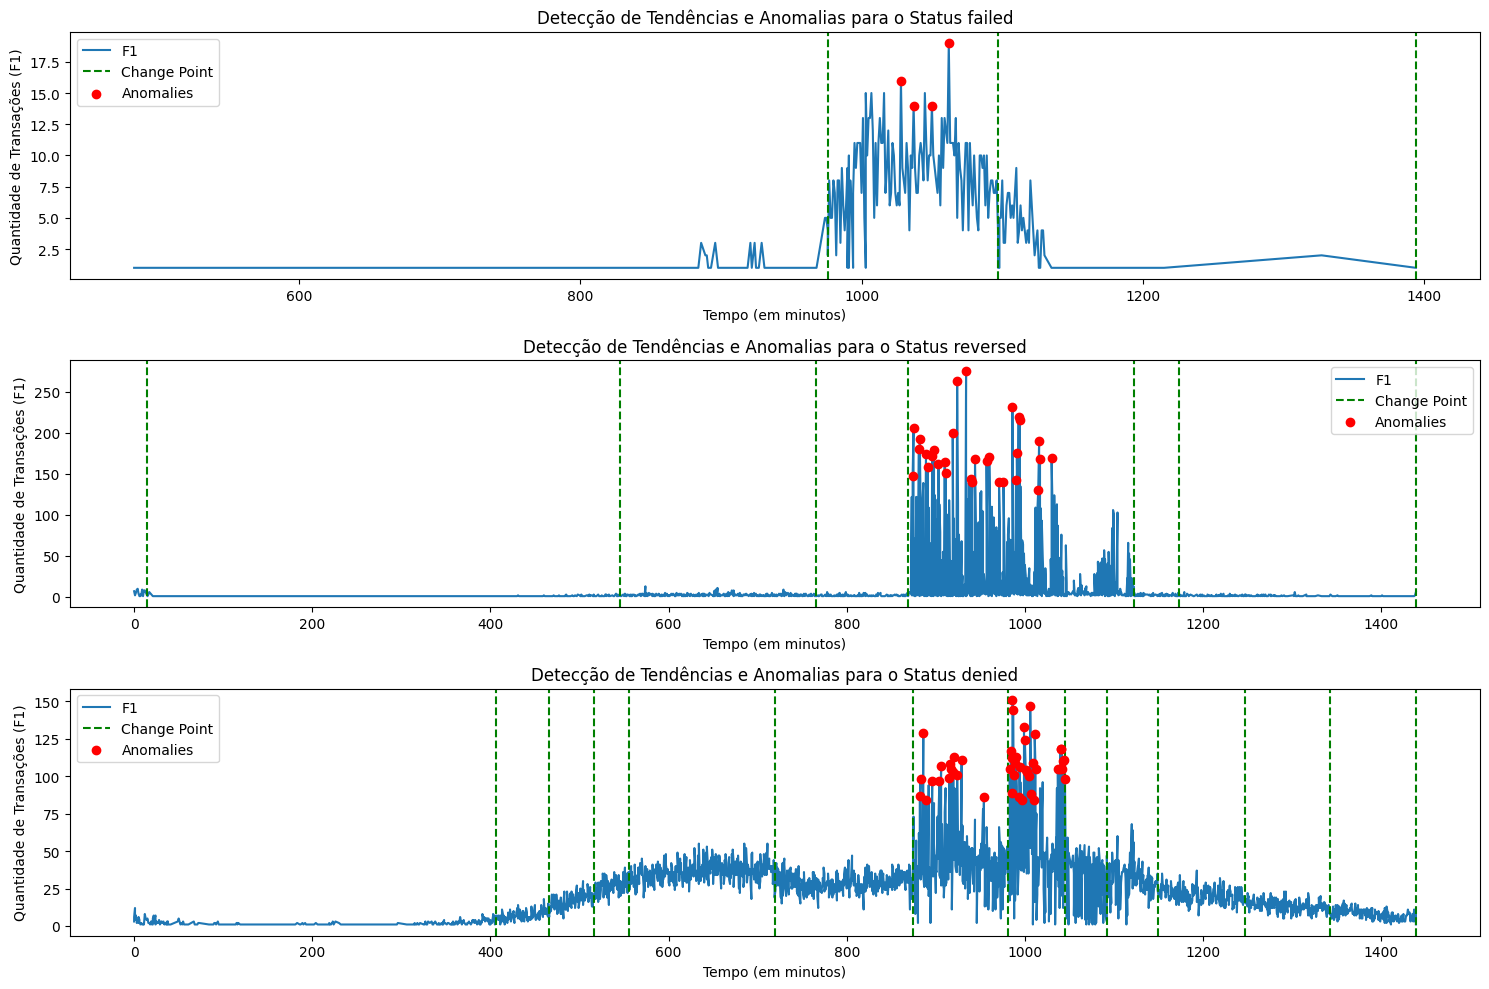

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from sklearn.ensemble import IsolationForest


df = transactions_concated

def detect_trends_and_anomalies(df, status):
    # Filtrar para um status específico
    status_df = df[df['status'] == status].copy()
    
    # Converter a coluna 'time' para datetime (se necessário)
    status_df['time'] = pd.to_datetime(status_df['time'], format='%H:%M:%S').dt.time
    
    # Converter 'time' para minutos desde o início do dia para simplificar
    status_df['time_in_minutes'] = status_df['time'].apply(lambda x: x.hour * 60 + x.minute)
    
    # Ordenar por tempo
    status_df = status_df.sort_values(by='time_in_minutes')
    
    # Usar apenas a coluna 'F1' para detectar mudanças
    signal = status_df['F1'].values
    
    # Detecção de rupturas
    model = rpt.Pelt(model="rbf").fit(signal)
    breakpoints = model.predict(pen=5)
    
    # Detectar anomalias
    iso_forest = IsolationForest(contamination=0.02, random_state=42)
    status_df['anomaly'] = iso_forest.fit_predict(status_df[['F1']])
    
    return status_df, breakpoints

statuses_of_interest = ['failed', 'reversed', 'denied']
results = {}
breakpoints_dict = {}

for status in statuses_of_interest:
    status_results, breakpoints = detect_trends_and_anomalies(df, status)
    results[status] = status_results
    breakpoints_dict[status] = breakpoints

# Exibir resultados
for status in statuses_of_interest:
    print(f"Resultados para o status '{status}':")
    print(results[status])
    print(f"\nPontos de mudança para o status '{status}':")
    print(breakpoints_dict[status])
    print("\n")

# Plotar os resultados para cada status
plt.figure(figsize=(15, 10))

for i, status in enumerate(statuses_of_interest):
    plt.subplot(3, 1, i + 1)
    status_df = results[status]
    signal = status_df['F1'].values
    breakpoints = breakpoints_dict[status]
    
    # Plotando o sinal
    plt.plot(status_df['time_in_minutes'], signal, label='F1')
    
    # Plotando os pontos de mudança
    for bp in breakpoints:
        plt.axvline(x=status_df['time_in_minutes'].iloc[bp-1], color='green', linestyle='--', label='Change Point' if bp == breakpoints[0] else "")
    
    # Destacar anomalias
    anomalies = status_df[status_df['anomaly'] == -1]
    plt.scatter(anomalies['time_in_minutes'], anomalies['F1'], color='red', label='Anomalies', zorder=5)
    
    plt.title(f'Detecção de Tendências e Anomalias para o Status {status}')
    plt.xlabel('Tempo (em minutos)')
    plt.ylabel('Quantidade de Transações (F1)')
    plt.legend()

plt.tight_layout()
plt.show()




## Creating the Model to Predict Anomalous Data

                   time    status   F1
0   1900-01-01 03:35:00  approved    6
1   1900-01-01 05:21:00  approved    4
2   1900-01-01 05:22:00  approved    5
3   1900-01-01 05:28:00  approved    4
4   1900-01-01 05:30:00  approved    5
..                  ...       ...  ...
90  1900-01-01 17:05:00  approved  535
91  1900-01-01 17:15:00  approved  560
92  1900-01-01 17:34:00  reversed    7
93  1900-01-01 17:42:00    failed   19
94  1900-01-01 17:46:00  reversed    7

[95 rows x 3 columns]


C:\Users\cassi\AppData\Local\Temp\ipykernel_9924\683312391.py:47: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  anomalias_por_minuto_tipo = anomalias.resample('T').size().reset_index(name='num_anomalias')
C:\Users\cassi\AppData\Local\Temp\ipykernel_9924\683312391.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anomalias_por_minuto = pd.concat([anomalias_por_minuto, anomalias_por_minuto_tipo])
C:\Users\cassi\AppData\Local\Temp\ipykernel_9924\683312391.py:47: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  anomalias_por_minuto_tipo = anomalias.resample('T').size().reset_index(name='num_anomalias')
C:\Users\cassi\AppData\Local\Tem

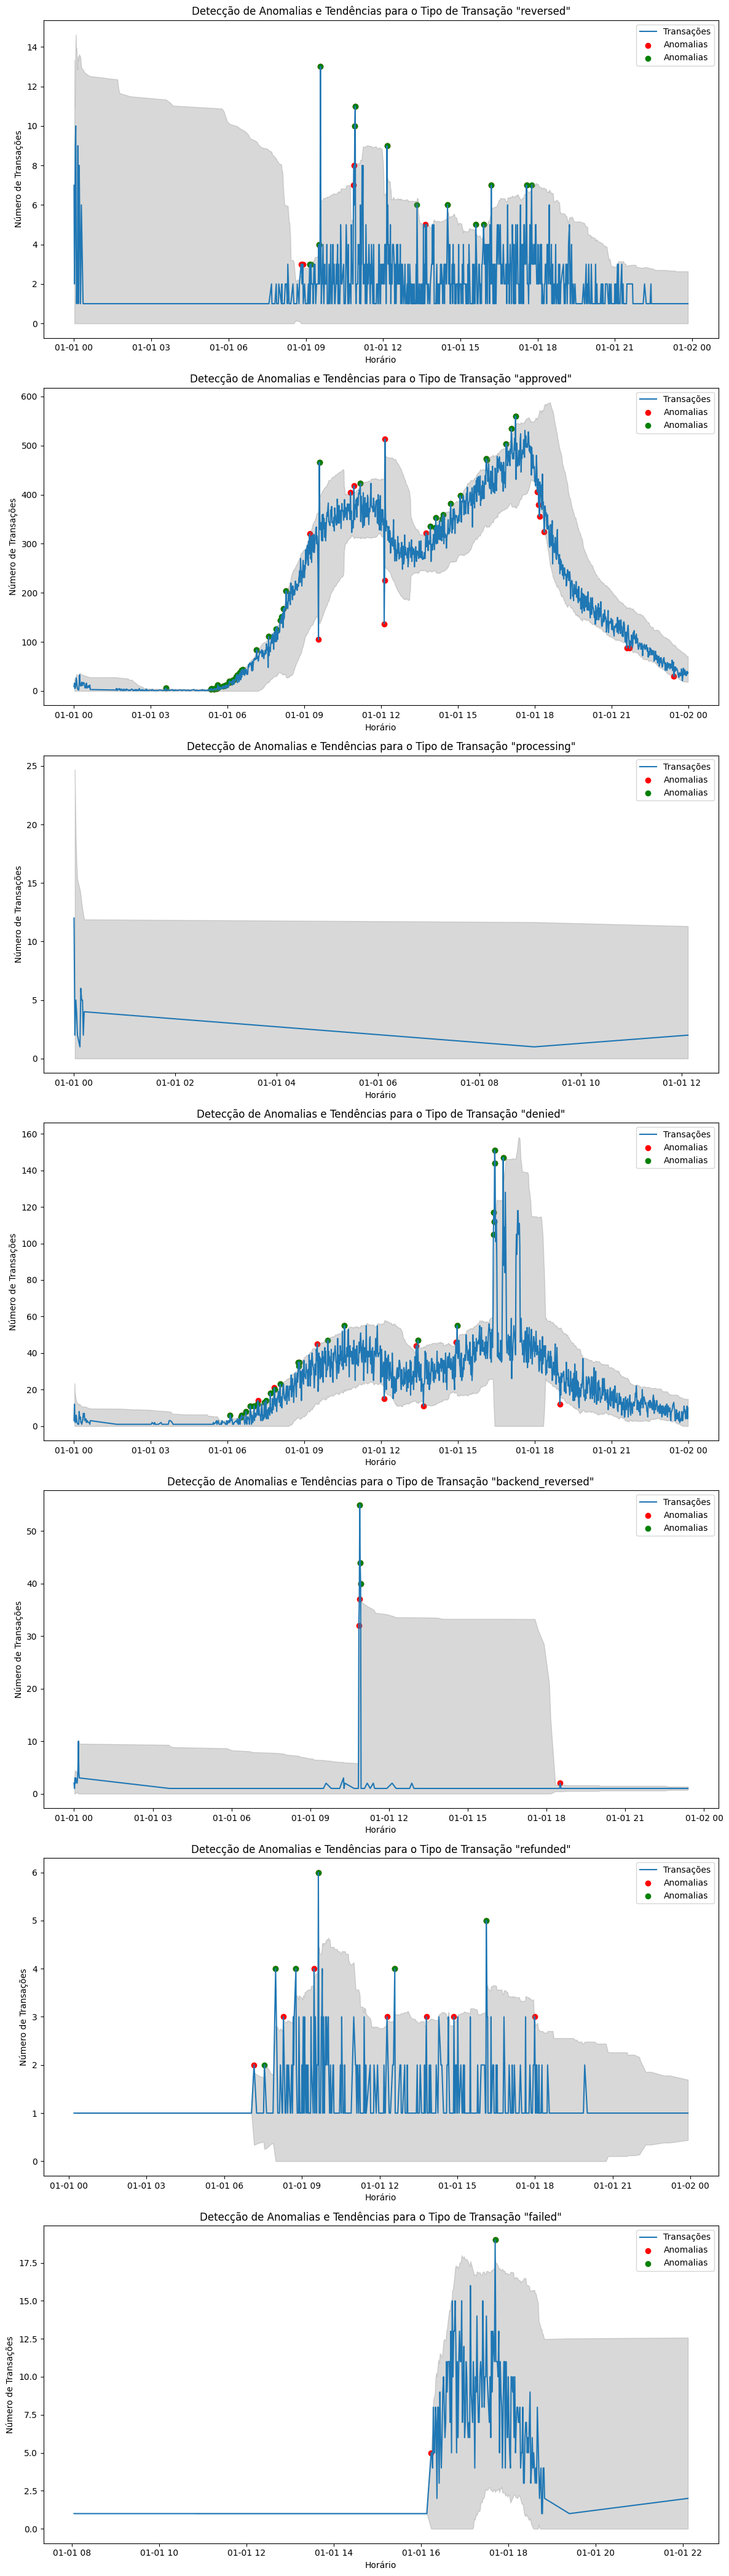

        status                time num_anomalias
0     approved 1900-01-01 03:35:00             1
1     approved 1900-01-01 03:36:00             0
2     approved 1900-01-01 03:37:00             0
3     approved 1900-01-01 03:38:00             0
4     approved 1900-01-01 03:39:00             0
...        ...                 ...           ...
1187  approved 1900-01-01 23:22:00             0
1188  approved 1900-01-01 23:23:00             0
1189  approved 1900-01-01 23:24:00             0
1190  approved 1900-01-01 23:25:00             0
1191  approved 1900-01-01 23:26:00             1

[3693 rows x 3 columns]


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


teste = pd.read_csv('output.csv', delimiter=';')
print(teste)

# Função para calcular média móvel e desvio padrão excluindo anomalias
def rolling_mean_std(data, window_size, sigma=2):
    rolling_mean = data.rolling(window=window_size, min_periods=1).mean()
    rolling_std = data.rolling(window=window_size, min_periods=1).std()
    return rolling_mean, rolling_std

# Carregar os dados de transações
df = pd.DataFrame(transactions_2)

# Inicializar uma figura e eixos para cada tipo de transação
fig, axes = plt.subplots(nrows=len(df['status'].unique()), figsize=(12, 6 * len(df['status'].unique())))

# Janela para cálculo da média móvel e desvio padrão móvel
window_size = 60  # Ajuste conforme necessário (em minutos)

# DataFrame para armazenar o número de anomalias por minuto para cada tipo de transação
anomalias_por_minuto = pd.DataFrame(columns=['status', 'time', 'num_anomalias'])

for tipo, ax in zip(df['status'].unique(), axes):
    data_tipo = df[df['status'] == tipo].copy()
    test = teste[teste['status'] == tipo].copy()
    
    
    # Definir índice de tempo
    data_tipo.set_index('time', inplace=True)
    
    # Calcular média móvel e desvio padrão móvel excluindo anomalias
    data_tipo['mean'], data_tipo['std'] = rolling_mean_std(data_tipo['F1'], window_size)
    
    # Definir limites para anomalias com base na média móvel e desvio padrão móvel
    data_tipo['limites_superiores'] = data_tipo['mean'] + 2.5 * data_tipo['std']  # Aumentando sigma para 3 para detectar pontos mais extremos
    data_tipo['limites_inferiores'] = data_tipo['mean'] - 2.5 * data_tipo['std']
    data_tipo['limites_inferiores'] = data_tipo['limites_inferiores'].apply(lambda x: max(x, 0))  # Garantir que o limite inferior não seja negativo

    # Identificar anomalias
    anomalias = data_tipo[(data_tipo['F1'] > data_tipo['limites_superiores']) | (data_tipo['F1'] < data_tipo['limites_inferiores'])]

    # Contar anomalias por minuto
    anomalias_por_minuto_tipo = anomalias.resample('T').size().reset_index(name='num_anomalias')
    anomalias_por_minuto_tipo['status'] = tipo
    anomalias_por_minuto = pd.concat([anomalias_por_minuto, anomalias_por_minuto_tipo])

    # Identificar tendências de subida e descida
    data_tipo['trend'] = data_tipo['mean'].diff()
    data_tipo['trend_direction'] = np.where(data_tipo['trend'] > 0, 'Subida', 'Descida')
    data_tipo['trend_direction'] = np.where(data_tipo['trend'] == 0, 'Estável', data_tipo['trend_direction'])

    # Reset index para plotagem
    data_tipo.reset_index(inplace=True)
    anomalias.reset_index(inplace=True)

    # Plotar resultados
    ax.plot(data_tipo['time'], data_tipo['F1'], label='Transações')
    ax.scatter(anomalias['time'], anomalias['F1'], color='red', label='Anomalias')
    ax.scatter(test['time'], test['F1'], color='green', label='Anomalias')
    
    # Adicionar área sombreada dentro dos limites estabelecidos
    ax.fill_between(data_tipo['time'], data_tipo['limites_superiores'], data_tipo['limites_inferiores'], color='grey', alpha=0.3)
    
    # Adicionar indicadores de tendência
    #for i in range(len(data_tipo['time']) - 1):
    #    if data_tipo['trend_direction'].iloc[i] == 'Subida':
    #        ax.axvline(data_tipo['time'].iloc[i], color='green', linestyle='--', alpha=0.5)
    #    elif data_tipo['trend_direction'].iloc[i] == 'Descida':
    #        ax.axvline(data_tipo['time'].iloc[i], color='red', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Horário')
    ax.set_ylabel('Número de Transações')
    ax.set_title(f'Detecção de Anomalias e Tendências para o Tipo de Transação "{tipo}"')
    ax.legend()

# Ajustar layout para evitar sobreposição de figuras
plt.tight_layout()
plt.show()

# Exibir o número de anomalias por minuto de cada status
print(anomalias_por_minuto.sort_values(by='time'))


In [126]:
anomalias_por_minuto.sort_values(by='time')

,status,time,num_anomalias
0,approved,1900-01-01 03:35:00,1
1,approved,1900-01-01 03:36:00,0
2,approved,1900-01-01 03:37:00,0
3,approved,1900-01-01 03:38:00,0
4,approved,1900-01-01 03:39:00,0
...,...,...,...
1187,approved,1900-01-01 23:22:00,0
1188,approved,1900-01-01 23:23:00,0
1189,approved,1900-01-01 23:24:00,0
1190,approved,1900-01-01 23:25:00,0
